In [1]:
# Define environment variables for Spark and Hadoop
import os

os.environ['HADOOP_CONF_DIR'] = r'C:\\Hadoop\\etc\\hadoop'
os.environ['HADOOP_HOME'] = r'C:\\Hadoop'
os.environ['PYSPARK_PYTHON'] = r'C:\\Users\\Hieu\\AppData\\Local\\Microsoft\\WindowsApps\\python3.10.exe'
os.environ['JAVA_HOME'] = r'C:\\Program Files\\Microsoft\\jdk-11.0.29.7-hotspot'
os.environ['SPARK_HOME'] = r'C:\\Spark'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'lab'
os.environ['SPARK_VERSION'] = '3.5.7'

In [2]:
# Initialize findspark
import findspark
findspark.init("C:\\Spark")

In [3]:
# Import section
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [4]:
# Initialize Spark Session
spark = (
    SparkSession.builder.appName("BrainTumorClassification")
    .master("yarn")
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "4g")
    .config("spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version", "1")
    .getOrCreate()
)

sc = spark.sparkContext

print("Spark Session initilized!")
print(spark.version)
print(sc.uiWebUrl)

Spark Session initilized!
3.5.7
http://192.168.1.2:4040


In [5]:
# Constant
HDFS_PATH_BASE = "hdfs://localhost:19000/user/bda501/brain_tumor/"
PROCESSED_PATH = HDFS_PATH_BASE + "processed/"

In [6]:
# Read processed data
processed_df = spark.read.parquet(PROCESSED_PATH)

# Prepare data for ML
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
df_with_vectors = processed_df.withColumn(
    "ml_features", list_to_vector_udf(col("features"))
).select("path", "label", "ml_features")
df_with_vectors.printSchema()

# Split data into training and test sets
(trainingData, testData) = df_with_vectors.randomSplit([0.8, 0.2], seed=42)

print(f"Training Data Count: {trainingData.count()}")
print(f"Test Data Count: {testData.count()}")
    
# Pipeline stages
label_indexer = StringIndexer(
    inputCol="label", 
    outputCol="indexedLabel"
).setHandleInvalid("keep")

rf = RandomForestClassifier(
    labelCol="indexedLabel", 
    featuresCol="ml_features",
    numTrees=200,
    maxDepth=20
)

mlp = MultilayerPerceptronClassifier(
    labelCol="indexedLabel",
    featuresCol="ml_features",
    maxIter=200,
    layers=[1280, 256, 64, 4],
    blockSize=128,
    seed=42
)

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- ml_features: vector (nullable = true)

Training Data Count: 4637
Test Data Count: 1075


In [7]:
# Train and evaluate Random Forest model
pipeline = Pipeline(stages=[label_indexer, rf])

# Train model
model_rf = pipeline.fit(trainingData)

# Evaluate model
predictions = model_rf.transform(testData)

predictions.select("path", "label", "prediction", "indexedLabel").show(20)

# Show report
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = evaluator_acc.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel",
    predictionCol="prediction",
    metricName="f1"
)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Test Accuracy (Random Forest) = {accuracy}")
print(f"Test F1 Score (Random Forest) = {f1_score}")

+--------------------+------+----------+------------+
|                path| label|prediction|indexedLabel|
+--------------------+------+----------+------------+
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       2.0|         3.0|
|hdfs://localhost:...|glioma|       2.0|         3.0|
|hdfs://localhost:...|glioma|       2.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma

In [8]:
# Train and evaluate MLP model
pipeline = Pipeline(stages=[label_indexer, mlp])

# Train model
model_mlp = pipeline.fit(trainingData)

# Evaluate model
predictions = model_mlp.transform(testData)

predictions.select("path", "label", "prediction", "indexedLabel").show(20)

# Show report
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = evaluator_acc.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel",
    predictionCol="prediction",
    metricName="f1"
)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Test Accuracy (MLP) = {accuracy}")
print(f"Test F1 Score (MLP) = {f1_score}")

+--------------------+------+----------+------------+
|                path| label|prediction|indexedLabel|
+--------------------+------+----------+------------+
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       2.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma|       3.0|         3.0|
|hdfs://localhost:...|glioma

C:\Spark\python\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix (MLP):
[[296.   1.   8.   0.]
 [  0. 265.  10.   2.]
 [  9.  13. 201.  22.]
 [  0.   2.  15. 231.]]


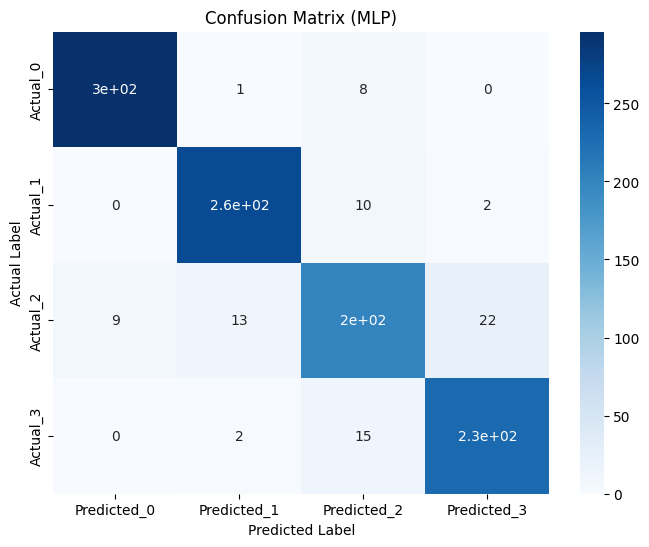

In [15]:
# Show confusion matrix of MLP model
preds_and_labels = predictions.select("prediction", "indexedLabel").rdd.map(lambda row: (row[0], row[1]))
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(preds_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix (MLP):")
print(confusion_matrix)

# Convert confusion matrix plot to pandas DataFrame for better visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
confusion_df = pd.DataFrame(
    confusion_matrix, 
    index=[f"Actual_{i}" for i in range(confusion_matrix.shape[0])],
    columns=[f"Predicted_{i}" for i in range(confusion_matrix.shape[1])]
)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, cmap='Blues')
plt.title("Confusion Matrix (MLP)")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [10]:
# Save MLP trained model to HDFS
model_mlp.write().overwrite().save(HDFS_PATH_BASE + "models/mlp_model")
print("MLP model saved to HDFS successfully.")

MLP model saved to HDFS successfully.


In [16]:
# stop spark
spark.stop()